#Ансамбли



In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

**Загрузка данных и включение в работу fetch_lfw_people**:




In [13]:
from sklearn.datasets import fetch_lfw_people # изображения лиц людей (медийно известные персоны)
faces = fetch_lfw_people(min_faces_per_person=100)  # берем 30 фотографий на персону  
print(faces.target_names)  #  покажем список полученых персон
print(faces.images.shape)  #  размеры данных (картинки 62 на 47 пикселей)

['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
(1140, 62, 47)


In [14]:
type(faces.images)

numpy.ndarray

In [15]:
import pickle

In [16]:
with open('face_data100.pickle', 'wb') as f:
...     pickle.dump(faces.data, f)
with open('face_images100.pickle', 'wb') as f:
...     pickle.dump(faces.images, f)

In [17]:
with open('data.pickle', 'rb') as f:
...     faces = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'data.pickle'

Задача представляет n классов, т.е. нужно использовать многоклассовую версию  классификаторов 


Каждый пример содержит 62 * 47 пикселей - таким образом исходных ("сырых") признаков очень много. Сделаем стандартную обработку с целью понизить размерность данных (используем РСА преобразование - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca - его особенности обсудим позднее. Пока важно, что из 62 * 47 признаков получим 150 признаков, что уже подходит для работы в пространстве примеров. где всего 2378 объектов )


Кроме того , используем механизм конвейеров обработки (пайплайны https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html ). Для этого существует специализированный класс Pipeline, который позволяет объединять отдельные этапы обработки данных (преобразования и обучение ) в один общий объект. Этот общий объект можно создавать разными способами. тут используем  функцию make_pipeline, куда передаем созданные объекты преобразования данных и классификатор (pca, clf).

Визуализируем примеры из набора данных:



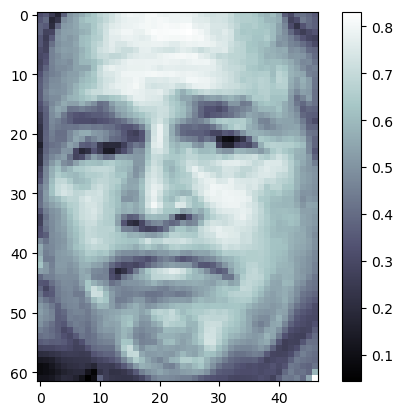

In [18]:
plt.imshow(faces.images[0], cmap='bone')
plt.colorbar()
plt.show()

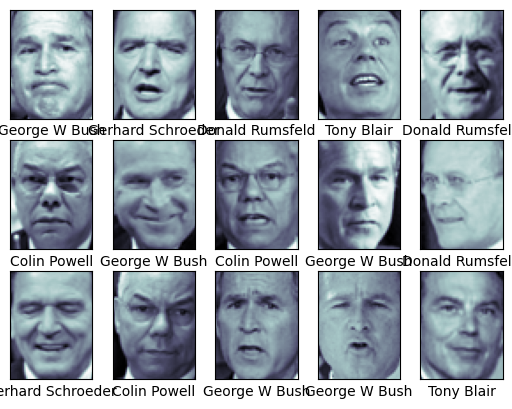

In [19]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Готовим данные для обучения и теста:

In [20]:
print(faces.data)

[[0.31895426 0.34901962 0.25882354 ... 0.4        0.5529412  0.82483655]
 [0.20915033 0.1882353  0.26928106 ... 0.9267974  0.89673203 0.86928105]
 [0.14509805 0.151634   0.15947713 ... 0.3882353  0.2784314  0.23006536]
 ...
 [0.8457516  0.83398694 0.8091503  ... 0.57124186 0.5437909  0.62614375]
 [0.37254903 0.4640523  0.52418303 ... 0.86928105 0.8379085  0.5124183 ]
 [0.13594772 0.3124183  0.4248366  ... 0.09411765 0.14379086 0.08235294]]


In [21]:
import sklearn.tree as tree
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline # сборка конвейера обработки.

# сделаем преобразование  
pca = PCA(n_components=150, whiten=True, random_state=42)
clf = tree.DecisionTreeClassifier (class_weight='balanced')


In [23]:
print(Xtrain)

[[0.17124183 0.17385621 0.19607843 ... 0.05620915 0.06535948 0.07843138]
 [0.7921569  0.772549   0.6470589  ... 0.1006536  0.3529412  0.3267974 ]
 [0.16993465 0.18431373 0.20261438 ... 0.91764706 0.9163399  0.94640523]
 ...
 [0.22352941 0.2130719  0.1633987  ... 0.84444445 0.42222223 0.12810458]
 [0.42222223 0.4745098  0.47843137 ... 0.15947713 0.16732027 0.16862746]
 [0.43137255 0.43529412 0.5137255  ... 0.21437909 0.06405229 0.08366013]]


In [22]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

pca.fit(Xtrain)

PCA(n_components=150, random_state=42, whiten=True)

Для поиска хорошей комбинации параметров пользуемся методом **случайного** перебора случайных вариантов из списка. работает быстрее чем сеточный поиск (просмотрит заранее заданное число вариантов гиперпараметров) но не обязательно найдет лучшее сочетание (что может сделать  **сеточный поиск**).

Запустим механизм случайного поиска для формирования наиболее эффективного набора гиперпараметров алгоритм:
  
  - используем объект RandomizedSearchCV(случайный поиск https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV)
  - в качестве пространства поиска зададим список параметров:
      - {'max_depth': [1, 5, 7,10,12,20, 50],
              'max_features': [0.1, 0.5, 0.7, 0.9]}


  Итогом работы этого объекта является комбинация параметров (.best_params_) с лучшей оценкой и наиболе качественная модель (.best_estimator_)
  
  Работает сравнительно быстро!!!     

In [58]:
from sklearn.model_selection import  RandomizedSearchCV  # для создания механизма random поиска.
param_grid = {'max_depth': [1, 5, 7,10,12,20, 50],
              'max_features': [0.1, 0.5, 0.7, 0.9]}
grid = RandomizedSearchCV(clf, param_grid)  # создаем объект для сеточного поиска.

%time grid.fit(pca.transform(Xtrain), ytrain)  # проводим сеточный поиск лучшей модели по гиперпараметрам
#print(grid.best_params_)  # лучшие параметры



Wall time: 5.03 s


RandomizedSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced'),
                   param_distributions={'max_depth': [1, 5, 7, 10, 12, 20, 50],
                                        'max_features': [0.1, 0.5, 0.7, 0.9]})

Лучшие параметры:

In [59]:
grid.best_params_

{'max_features': 0.7, 'max_depth': 12}

Проверяем качество на тестовых примерах

In [60]:
model = grid.best_estimator_  # лучшая модель по версии сеточного поиска (уже обучена в процессе сеточного поиска)
yfit = model.predict(pca.transform(Xtest))  # применяем эту модель к нашим тестам


Визуализируем тесты:

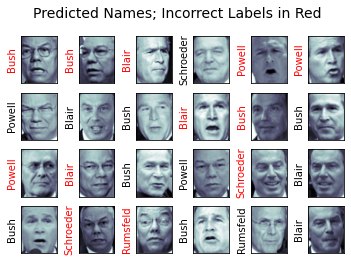

In [61]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Заодно смотрим на тренировочном наборе:

In [62]:
yfit_tr = model.predict(pca.transform(Xtrain))

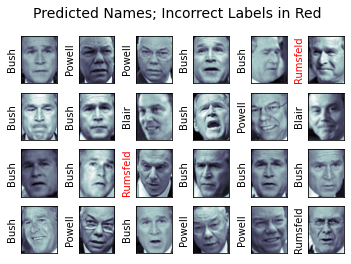

In [63]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtrain[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit_tr[i]].split()[-1],
                   color='black' if yfit_tr[i] == ytrain[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Ошибает. но значительно меньше. Посчитаем метрики.

Оцениваем результаы по всем классам на тестах:

In [64]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       0.46      0.41      0.43        64
  Donald Rumsfeld       0.64      0.50      0.56        32
    George W Bush       0.62      0.73      0.67       127
Gerhard Schroeder       0.35      0.24      0.29        29
       Tony Blair       0.30      0.30      0.30        33

         accuracy                           0.53       285
        macro avg       0.47      0.44      0.45       285
     weighted avg       0.52      0.53      0.52       285



Очень слабая генерализация модели : **слишком глубокое дерево?** - проверьте , уменьшая глубину от найденого лучшего сочетания параметров: 

[Text(0.39108664772727275, 0.9615384615384616, 'x[16] <= -0.68\ngini = 0.8\nsamples = 855\nvalue = [171.0, 171.0, 171.0, 171.0, 171.0]'),
 Text(0.12613636363636363, 0.8846153846153846, 'x[37] <= 0.007\ngini = 0.624\nsamples = 201\nvalue = [34.797, 122.966, 37.764, 12.825, 10.784]'),
 Text(0.05795454545454545, 0.8076923076923077, 'x[13] <= -0.905\ngini = 0.759\nsamples = 97\nvalue = [23.86, 24.978, 21.64, 6.413, 9.243]'),
 Text(0.01818181818181818, 0.7307692307692307, 'x[1] <= 0.107\ngini = 0.492\nsamples = 22\nvalue = [13.919, 0.0, 2.546, 4.275, 0.0]'),
 Text(0.00909090909090909, 0.6538461538461539, 'x[122] <= -1.823\ngini = 0.0\nsamples = 12\nvalue = [11.93, 0.0, 0.0, 0.0, 0.0]'),
 Text(0.004545454545454545, 0.5769230769230769, 'gini = 0.0\nsamples = 1\nvalue = [0.994, 0.0, 0.0, 0.0, 0.0]'),
 Text(0.013636363636363636, 0.5769230769230769, 'gini = 0.0\nsamples = 11\nvalue = [10.936, 0.0, 0.0, 0.0, 0.0]'),
 Text(0.02727272727272727, 0.6538461538461539, 'x[13] <= -1.289\ngini = 0.63\nsam

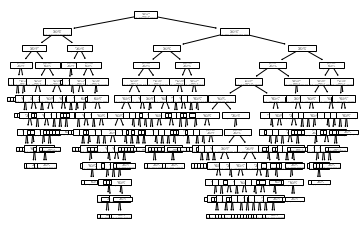

In [65]:
tree.plot_tree(model)

Строим матрицу ошибок:

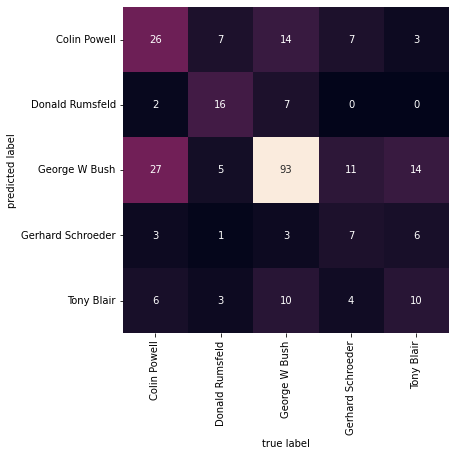

In [66]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, yfit)
plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Главная диагональ - верные классификации, а все вне этой диагонали разнородные ошибки (как оценки модели принимают один тип объектов за другой)

Что-то реально нашли только в трех классах.

In [67]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [68]:
rf = RandomForestClassifier(n_estimators=150,  max_depth=100)

rf.fit(pca.transform(Xtrain), ytrain)
yfit_tr = rf.predict(pca.transform(Xtrain))
yfit = rf.predict(pca.transform(Xtest))


print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Colin Powell       1.00      0.50      0.67        64
  Donald Rumsfeld       1.00      0.06      0.12        32
    George W Bush       0.53      1.00      0.70       127
Gerhard Schroeder       1.00      0.17      0.29        29
       Tony Blair       0.88      0.21      0.34        33

         accuracy                           0.61       285
        macro avg       0.88      0.39      0.42       285
     weighted avg       0.78      0.61      0.54       285



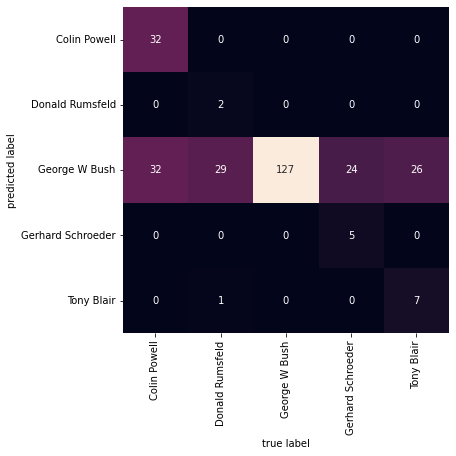

In [69]:
mat = confusion_matrix(ytest, yfit)
plt.figure(figsize=(6,6))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Результаты лучше: деревья в ансамбле много и они глубокие. Ниже одно из первых деревьев

[Text(0.3128559883004926, 0.9666666666666667, 'x[15] <= -0.108\ngini = 0.707\nsamples = 548\nvalue = [169, 82, 394, 78, 132]'),
 Text(0.07562346059113301, 0.9, 'x[88] <= -1.401\ngini = 0.669\nsamples = 231\nvalue = [30, 32, 188, 46, 70]'),
 Text(0.024630541871921183, 0.8333333333333334, 'x[26] <= -0.059\ngini = 0.58\nsamples = 17\nvalue = [1, 3, 7, 0, 15]'),
 Text(0.014778325123152709, 0.7666666666666667, 'x[9] <= 0.076\ngini = 0.255\nsamples = 8\nvalue = [1, 1, 0, 0, 12]'),
 Text(0.009852216748768473, 0.7, 'x[68] <= 1.517\ngini = 0.5\nsamples = 2\nvalue = [1, 1, 0, 0, 0]'),
 Text(0.0049261083743842365, 0.6333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0, 0, 0]'),
 Text(0.014778325123152709, 0.6333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0, 0]'),
 Text(0.019704433497536946, 0.7, 'gini = 0.0\nsamples = 6\nvalue = [0, 0, 0, 0, 12]'),
 Text(0.034482758620689655, 0.7666666666666667, 'x[117] <= -0.088\ngini = 0.569\nsamples = 9\nvalue = [0, 2, 7, 0, 3]'),
 Text(0

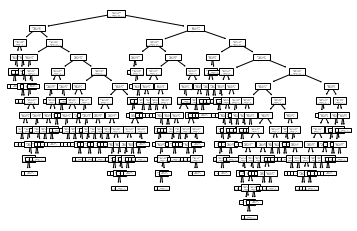

In [70]:
i = 0
tree.plot_tree(rf.estimators_[i])

### **Задание 1.**

Самостоятельно оценить данные по варианту (или любой рабочий набор данных для классификации с числом объектов больше 500):

In [71]:
import sklearn
V1 = sklearn.datasets.load_wine()
V2 = sklearn.datasets.load_digits()
V3 = sklearn.datasets.load_breast_cancer()
V4 = sklearn.datasets.make_classification(n_samples = 1000, n_features=10, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = sklearn.datasets.make_blobs(n_samples=1000, centers=2, n_features=5, random_state=10)

In [72]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
Xtrain, Xtest, ytrain, ytest = train_test_split(V4[0], V4[-1], random_state=42)
rfc.fit(Xtrain, ytrain)
ypred = rfc.predict(Xtest)

print(classification_report(ytest, ypred, target_names=V3.target_names))

              precision    recall  f1-score   support

   malignant       0.88      0.94      0.91       120
      benign       0.94      0.88      0.91       130

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



Сравнить с результатом логистической регрессии, деревьями, knn.

In [73]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)
rfc_scaled = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rfc_scaled.fit(Xtrain_scaled, ytrain)
ypred_scaled = rfc_scaled.predict(Xtest_scaled)

print(classification_report(ytest, ypred_scaled, target_names=V3.target_names))

              precision    recall  f1-score   support

   malignant       0.88      0.94      0.91       120
      benign       0.94      0.88      0.91       130

    accuracy                           0.91       250
   macro avg       0.91      0.91      0.91       250
weighted avg       0.91      0.91      0.91       250



 1.1.Загрузить данные  по варианту 

 1.2.Построить классификатор случайный лес в формате sklearn  .
 
 1.3. Выбрать метрику (учитываем балансировку данных и смысл задачи) и оценить качество модели на отложенной выборке
 
 1.4. сделать выводы о качестве для модели на основе выбранной метрики

 1.5. Привести все признаки к одному диапазону (0,1) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) или провести стандартизацию признаков (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) , построить модель в sklearn и оценить метрики на отложеной выборке
 
 1.6. Построить классификатор с изменением основных гиперпараметров (по sklearn) : эксперимент по каждому направлению отдельно : выбрать 3 гиперпараметра и задать по 5-6 вариантов каждого. Зафиксировать в каждом эксперименте(при изменении одного из параметров) accuracy, f1,точность, полнота, РR_auc,  ROC_auc в таблице результатов.
 
 1.7 Сделать выводы о качестве модели

In [46]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

n_estimators = [10, 15, 20]
max_depth = [5, 10, 15]
min_samples_split = [2, 5, 10]


models = []
results = []

for n in n_estimators:
    for d in max_depth:
        for s in min_samples_split:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, min_samples_split=s, random_state=42)
            rf.fit(Xtrain_scaled, ytrain)
            y_pred = rf.predict(Xtest_scaled)
            acc = accuracy_score(ytest, y_pred)
            f1 = f1_score(ytest, y_pred, average='weighted')
            precision = precision_score(ytest, y_pred, average='weighted')
            recall = recall_score(ytest, y_pred, average='weighted')
            roc_auc = roc_auc_score(ytest, y_pred, multi_class='ovr', average='weighted')
            results.append([n, d, s, acc, f1, precision, recall, roc_auc])
            models.append(rf)


columns = ['n_estimators', 'max_depth', 'min_samples_split', 'accuracy', 'f1_score', 'precision', 'recall', 'roc_auc_score']
df_results = pd.DataFrame(results, columns=columns)
display(df_results)

best_model_index = df_results['roc_auc_score'].idxmax()
best_model = models[best_model_index]
print(f"The best model is:\n {best_model}")
print(f"ROC AUC score: {df_results['roc_auc_score'].max()}")

,n_estimators,max_depth,min_samples_split,accuracy,f1_score,precision,recall,roc_auc_score
0,10,5,2,0.912,0.912023,0.913914,0.912,0.913141
1,10,5,5,0.912,0.912023,0.913914,0.912,0.913141
2,10,5,10,0.908,0.908031,0.909486,0.908,0.908974
3,10,10,2,0.896,0.896040,0.896539,0.896,0.896474
4,10,10,5,0.900,0.900034,0.901479,0.900,0.900962
5,10,10,10,0.880,0.880000,0.882821,0.880,0.881410
6,10,15,2,0.848,0.848039,0.848186,0.848,0.848077
7,10,15,5,0.880,0.880031,0.881865,0.880,0.881090
8,10,15,10,0.884,0.884039,0.885464,0.884,0.884936
9,15,5,2,0.916,0.916028,0.917493,0.916,0.916987


The best model is:
 RandomForestClassifier(max_depth=5, n_estimators=15, random_state=42)
ROC AUC score: 0.9169871794871794


Работа с данными типа изображение на примере faces:

  - все точки изображения хранятся в 2-х видах: faces.data[i,:] - вектор (длины 2914) и faces.image[i] матрица (67х43). Они являются признаками объекта для обучения модели
  - наши классификаторы принимают на вход только векторные формы данных
  - для изменения содержания объекта изображения нужно брать данные из faces.image[i] - обрабатывать их как изображения и превращать в вектора для использования в классификаторе
  - пример ниже : уменьшение размера анализируемой картинки примерно в 2 раза

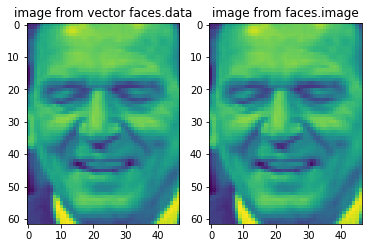

In [74]:
i = 10
plt.subplot(1,2,1)
plt.imshow(faces.data[i,:].reshape(62,47))
plt.title('image from vector faces.data')
plt.subplot(1,2,2)
plt.imshow(faces.images[i])
plt.title('image from faces.image')
plt.show()

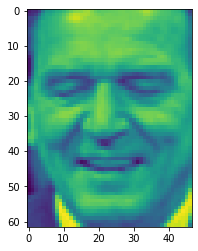

(2914,)


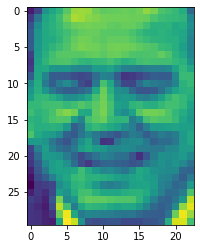

(1, 690)


In [75]:
from PIL import Image
i =  10
I = Image.fromarray((faces.images[i]*255).astype(np.uint8)) # картинку в диапазон 0, 255 и тип целые
I = I.resize((23,30))

plt.imshow(faces.images[i])
plt.show()
print(faces.data[i,:].shape)
plt.imshow(I)
plt.show()

data_2 = np.asarray(I).reshape(1,-1)/255 # картинку в вектор и обратно в диапазон 0,1
print(data_2.shape)

Задание 2.
Для  fetch_lfw_people:

2.1 .Построить несколько вариантов ансамбря Случайный лес с разными гиперпараметрами для случаев min_faces_per_person=50 и min_faces_per_person= 30.  (будет разное число классов и объектов в каждом сслучаее min_faces_per_person)

2.2. Для исходного min_faces_per_person=100 перед использованием РСА применить масштабирование данных (уменьшить размер картинок до 30х23)

2.3. Сравнить результаты по аккурантности всех вариантов

Вопросы для контроля:

  1. Что такое «проблема мультиколлинеарности» в задачах многомерной линейной регрессии? Возникает ли она для регрессии на деревьях.
  2. Какие критерии информативности используются при синтезе решающего дерева и почему?
  3. Достоинства и недостатки решающих деревьев.
  4. Зачем делается редукция решающих деревьев?
  5. Основная идея алгоритма СART?
  6. Как происходит перебор в жадном алгоритме синтеза дерева?
  7. Какой алгоритм строит дерево минимальной высоты?
  8. Как сказывается увеличение глубины дерева на качестве анализа новых объектов
  9. Как сократить перебор при построении дерева
  10. перечислите критерии останова

In [ ]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

accuracy_list = []
for min_faces_per_person in [30, 50]:
  faces = fetch_lfw_people(min_faces_per_person=min_faces_per_person)
  # print(faces.target_names)
  # print(faces.images.shape)

  Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target, random_state=42)
  pca = PCA(n_components=150, whiten=True)
  pca.fit(Xtrain)

  for n_estimators in [10, 20, 30]:
      for max_depth in [5, 8, 12]:
          clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
          clf.fit(pca.transform(Xtrain), ytrain)
          ypred = clf.predict(pca.transform(Xtest))
          accuracy = accuracy_score(ypred, ytest)
          accuracy_list.append({'min_faces_per_person': min_faces_per_person,
                                'n_estimators': n_estimators, 
                                'max_depth': max_depth, 
                                'accuracy': accuracy})
          # print(f"n_estimators={n_estimators}, max_depth={max_depth}:")
          # print(classification_report(ytest, yfit, target_names=faces.target_names))
accuracy_list_df = pd.DataFrame(accuracy_list)
print(accuracy_list_df)

In [76]:
#2.1
#ЗДЕСЬ ДЛЯ 50

In [ ]:
faces = fetch_lfw_people(min_faces_per_person=50)
print(faces.target_names) 
print(faces.images.shape) 

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])